In [12]:
import numpy as np
import matplotlib.pyplot as plt


In [13]:
class HeatElement2D:
    def __init__(self, node_indices, node_coordinates, k):
        self.node_indices = node_indices
        self.node_coordinates = node_coordinates
        self.k = k  # Thermal conductivity
        self.local_stiffness_matrix = self.compute_local_stiffness_matrix()

    def compute_local_stiffness_matrix(self):
        # Number of nodes in the element
        num_nodes = 4
        K_local = np.zeros((num_nodes, num_nodes))

        # Gaussian quadrature points and weights (2x2 integration)
        gauss_points = [
            (-1/np.sqrt(3), -1/np.sqrt(3)),
            (1/np.sqrt(3), -1/np.sqrt(3)),
            (1/np.sqrt(3), 1/np.sqrt(3)),
            (-1/np.sqrt(3), 1/np.sqrt(3))
        ]
        gauss_weights = [1, 1, 1, 1]

        # Material property matrix (isotropic material)
        D = self.k * np.eye(2)

        for gp, weight in zip(gauss_points, gauss_weights):
            xi, eta = gp

            # Shape functions and their derivatives in natural coordinates
            N = np.array([
                0.25 * (1 - xi) * (1 - eta),
                0.25 * (1 + xi) * (1 - eta),
                0.25 * (1 + xi) * (1 + eta),
                0.25 * (1 - xi) * (1 + eta)
            ])

            dN_dxi = np.array([
                [-0.25 * (1 - eta), 0.25 * (1 - eta), 0.25 * (1 + eta), -0.25 * (1 + eta)],
                [-0.25 * (1 - xi), -0.25 * (1 + xi), 0.25 * (1 + xi), 0.25 * (1 - xi)]
            ])

            # Jacobian matrix
            J = dN_dxi @ self.node_coordinates
            det_J = np.linalg.det(J)

            # Inverse of the Jacobian matrix
            inv_J = np.linalg.inv(J)

            # Gradient of shape functions in global coordinates
            dN_dx = inv_J @ dN_dxi

            # B matrix (gradient matrix)
            B = dN_dx

            # Stiffness matrix contribution
            K_local += (B.T @ D @ B) * det_J * weight

        return K_local


In [14]:
class HeatSystem2D:
    def __init__(self, elements, num_nodes, boundary_conditions, heat_sources):
        self.elements = elements
        self.num_nodes = num_nodes
        self.boundary_conditions = boundary_conditions
        self.heat_sources = heat_sources


In [15]:
class Solver:
    def __init__(self, system):
        self.system = system

    def solve(self):
        # Assemble global matrices
        K_global, F_global = self.assemble_global_matrices()

        # Apply boundary conditions
        Kuu, Fu = self.apply_boundary_conditions(K_global, F_global)

        # Solve for unknown temperatures
        self.temperatures = self.solve_temperatures(Kuu, Fu)

        # Calculate reaction forces (heat fluxes)
        self.reaction_fluxes = self.get_reaction_fluxes(K_global, self.temperatures)

        return self.temperatures, self.reaction_fluxes

    def assemble_global_matrices(self):
        # Assemble global stiffness matrix
        num_nodes = self.system.num_nodes
        K_global = np.zeros((num_nodes, num_nodes))

        for element in self.system.elements:
            K_local = element.local_stiffness_matrix
            node_indices = element.node_indices

            for i, node_i in enumerate(node_indices):
                for j, node_j in enumerate(node_indices):
                    K_global[node_i, node_j] += K_local[i, j]

        # Assemble global force vector (heat sources)
        F_global = np.zeros(num_nodes)
        for node_index, heat_source in self.system.heat_sources:
            F_global[node_index] += heat_source

        return K_global, F_global

    def apply_boundary_conditions(self, K_global, F_global):
        # Identify known and unknown degrees of freedom (DOFs)
        known_dofs = [bc[0] for bc in self.system.boundary_conditions]
        unknown_dofs = [i for i in range(self.system.num_nodes) if i not in known_dofs]

        # Partition the global stiffness matrix and force vector
        Kuu = K_global[np.ix_(unknown_dofs, unknown_dofs)]
        Fu = F_global[unknown_dofs]

        # Modify the force vector to account for known temperatures
        for bc in self.system.boundary_conditions:
            node_index, temperature = bc
            # Extract the column corresponding to the known DOF and multiply by temperature
            Fu -= K_global[np.ix_(unknown_dofs, [node_index])].flatten() * temperature

        return Kuu, Fu

    def solve_temperatures(self, Kuu, Fu):
        # Solve for unknown temperatures
        Tu = np.linalg.solve(Kuu, Fu)

        # Merge known and unknown temperatures
        temperatures = np.zeros(self.system.num_nodes)
        known_dofs = [bc[0] for bc in self.system.boundary_conditions]
        unknown_dofs = [i for i in range(self.system.num_nodes) if i not in known_dofs]

        temperatures[unknown_dofs] = Tu
        for bc in self.system.boundary_conditions:
            node_index, temperature = bc
            temperatures[node_index] = temperature

        return temperatures

    def get_reaction_fluxes(self, K_global, temperatures):
        # Calculate reaction forces (heat fluxes) at boundary nodes
        reaction_fluxes = K_global @ temperatures

        # Zero out non-boundary reactions
        boundary_nodes = [bc[0] for bc in self.system.boundary_conditions]
        reaction_fluxes = np.where(np.isin(np.arange(self.system.num_nodes), boundary_nodes), reaction_fluxes, 0)

        return reaction_fluxes


In [16]:
class Plotter:
    def __init__(self, solver):
        self.solver = solver

    def plot_temperature_distribution(self, nodal_coordinates):
        x = nodal_coordinates[:, 0]
        y = nodal_coordinates[:, 1]
        T = self.solver.temperatures

        plt.tricontourf(x, y, T, levels=20, cmap='hot')
        plt.colorbar(label='Temperature')
        plt.title('2D Heat Diffusion')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.show()


## SOLUTIONS

In [17]:
# # Define connectivity and nodal coordinates
num_x = 50
num_y = 50
dx = 1/num_x
dy = 1/num_y

# Generate nodal coordinates
nodal_coordinates = np.array([[i * dx, j * dy] for j in range(num_y + 1) for i in range(num_x + 1)])

# Generate connectivity (each element is a quadrilateral)
connectivity = []
for j in range(num_y):
    for i in range(num_x):
        n1 = j * (num_x + 1) + i
        n2 = n1 + 1
        n3 = n1 + (num_x + 1)
        n4 = n3 + 1
        connectivity.append([n1, n2, n4, n3])

connectivity = np.array(connectivity)

# Define boundary conditions
boundary_conditions = []

T_bottom = 0 # Bottom boundary (y = 0) -> T = 0
T_top = 1 # Top boundary (y = num_y) -> T = 1
T_left = 0 # Left boundary (x = 0) -> T = 0
T_right = 0 # Right boundary (x = num_x) -> T = 0

bottom_nodes = range(0, num_x + 1)
boundary_conditions += [[i, T_bottom] for i in bottom_nodes]

top_nodes = range(num_x * (num_y + 1), (num_x + 1) * (num_y + 1))
boundary_conditions += [[i, T_top] for i in top_nodes]

left_nodes = range(0, (num_x + 1) * (num_y + 1), num_x + 1)
boundary_conditions += [[i, T_left] for i in left_nodes]

right_nodes = range(num_x, (num_x + 1) * (num_y + 1), num_x + 1)
boundary_conditions += [[i, T_right] for i in right_nodes]

# # Print results
# print("Nodal Coordinates:\n", nodal_coordinates)
# print("\nConnectivity:\n", connectivity)
# print("\nBoundary Conditions:\n", boundary_conditions)

# Define heat sources (node_index, heat_source)
heat_sources = [
    # [4, 10]  # Heat source at node 4
]

num_nodes = len(nodal_coordinates)
k = 1.0  # Thermal conductivity

# Create elements
elements = []
for node_indices in connectivity:
    node_coords = nodal_coordinates[node_indices]
    element = HeatElement2D(node_indices, node_coords, k)
    elements.append(element)

# Create system
system = HeatSystem2D(elements, num_nodes, boundary_conditions, heat_sources)


In [18]:
# Solve the system
solver = Solver(system)
temperatures, reaction_fluxes = solver.solve()

# # Print results
# print("Temperatures and Reaction Fluxes for All Nodes:")
# for node_id in range(num_nodes):
#     T = temperatures[node_id]
#     flux = reaction_fluxes[node_id]
#     print(f"Node: {node_id}, Temperature={T:.8f} °C, Reaction Flux={flux:.8f} W/m²")


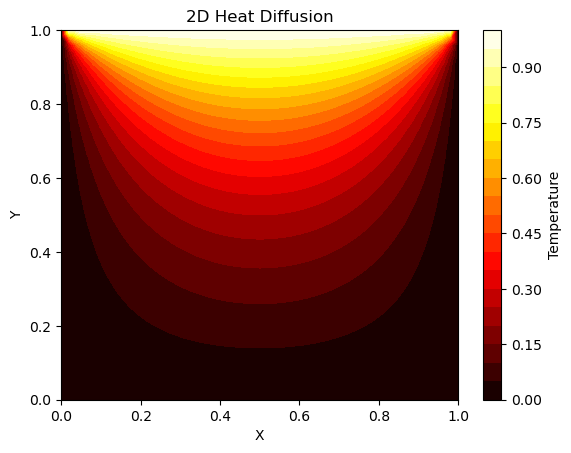

In [19]:
# Plot the results
plotter = Plotter(solver)
plotter.plot_temperature_distribution(nodal_coordinates)
